-----

# based kernel

- Stacked Regressions : Top 4% on LeaderBoard
  - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard



In [65]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns

color = sns.color_palette()
sns.set_style('darkgrid')

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


In [66]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [67]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [68]:
# drop Id column from train/test

print("train and test shape:", train.shape, test.shape)

train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)



train and test shape: (1460, 81) (1459, 80)


# Data Processing

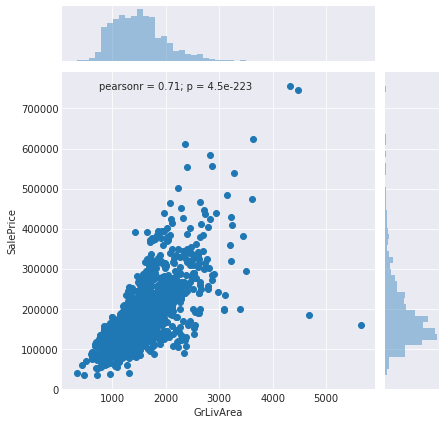

In [69]:
sns.jointplot(x="GrLivArea", y="SalePrice", data=train)

**todo: why Id 523, 1298 are outliers?**


In [70]:
# Outliers rows
train[(train["GrLivArea"] > 4000) & (train['SalePrice']< 300000)][train.dtypes[train.dtypes != "object"].index]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
523,60,130.0,40094,10,5,2007,2008,762.0,2260,0,...,208,406,0,0,0,0,0,10,2007,184750
1298,60,313.0,63887,10,5,2008,2008,796.0,5644,0,...,214,292,0,0,0,480,0,1,2008,160000


In [71]:
# mean and std
train.describe().loc[["mean", "std"], :]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883


### drop Outliers rows

- is it necessary to remove it?

In [72]:
train[(train["GrLivArea"] > 4000) & (train['SalePrice']< 300000)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


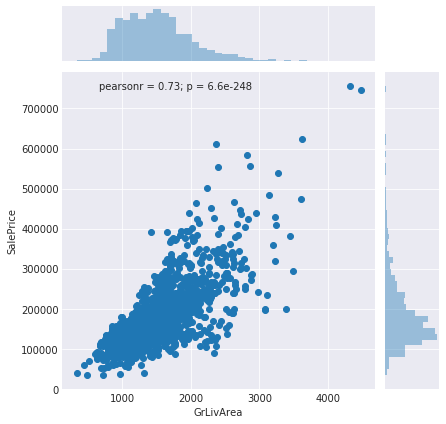

In [73]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

sns.jointplot(x="GrLivArea", y="SalePrice", data=train)

180932.91906721535 79467.78892987774


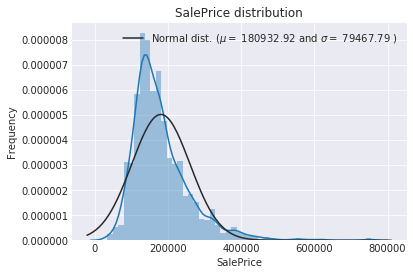

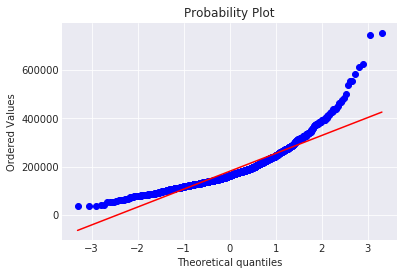

In [74]:
sns.distplot(train.SalePrice, fit=norm)

(mu, sigma) = norm.fit(train.SalePrice)
print(mu, sigma)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

12.024015155682552 0.3995757283645756


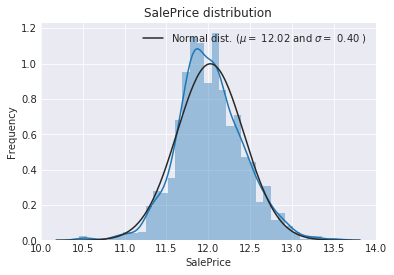

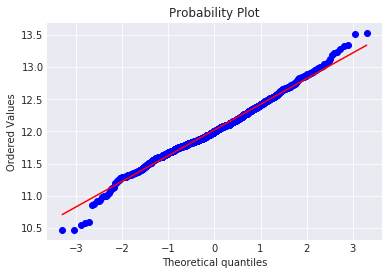

In [75]:
# apply logarithm transformation

train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train["SalePrice"], fit=norm)

(mu, sigma) = norm.fit(train['SalePrice'])
print(mu, sigma)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


## Feature engineering

In [76]:
# get y target values
# and convine all train/test data to one data frame

ntrain = train.shape[0]
ntest = train.shape[0]
print("num of train/test", ntrain, ntest)

y_train = train.SalePrice.values
#print("train shape", y_train.shape, y_train)

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data shape", all_data.shape)

num of train/test 1458 1458
all_data shape (2917, 79)


### show na value rate

In [77]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(
    ascending=False)
all_data_na.head()

PoolQC         99.691464
MiscFeature    96.400411
Alley          93.212204
Fence          80.425094
FireplaceQu    48.680151
dtype: float64

In [78]:
all_data_na = (all_data.isnull().sum()/len(all_data))*100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(
    ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5,1,'Percent missing data by feature')

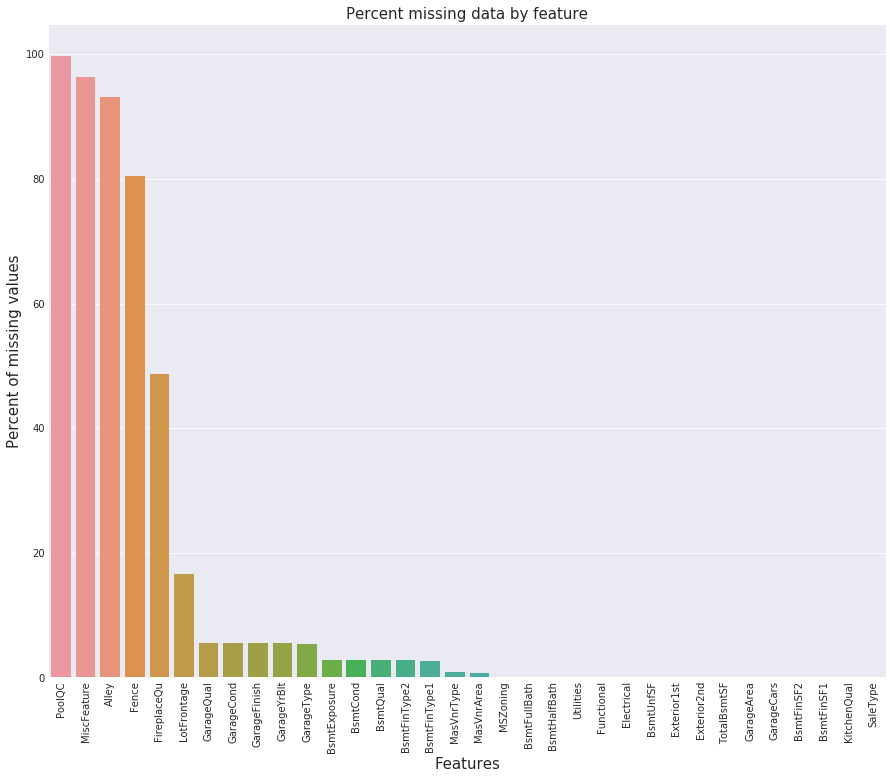

In [79]:
# just plot the rate

f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

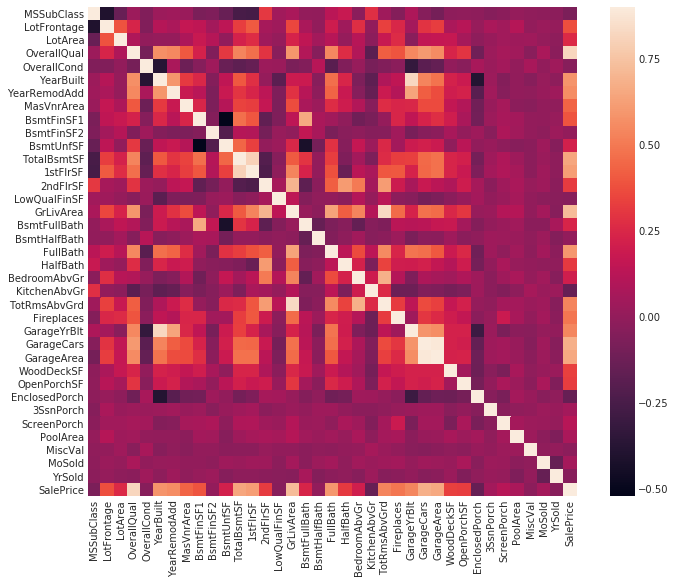

In [80]:
# plot corr
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

# Imputing missing values

In [81]:
all_data[["PoolQC", 'MiscFeature', 'Alley',
          'Fence', 'FireplaceQu', 'LotFrontage']].dtypes

PoolQC          object
MiscFeature     object
Alley           object
Fence           object
FireplaceQu     object
LotFrontage    float64
dtype: object

In [82]:
all_data[["PoolQC", 'MiscFeature', 'Alley',
          'Fence', 'FireplaceQu', 'LotFrontage']].head()

,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage
0,NaN,NaN,NaN,NaN,NaN,65.0
1,NaN,NaN,NaN,NaN,TA,80.0
2,NaN,NaN,NaN,NaN,TA,68.0
3,NaN,NaN,NaN,NaN,Gd,60.0
4,NaN,NaN,NaN,NaN,TA,84.0


In [83]:
all_data.PoolQC.value_counts(dropna=False)

NaN    2908
Ex        4
Gd        3
Fa        2
Name: PoolQC, dtype: int64

In [84]:
all_data.MiscFeature.value_counts(dropna=False)

NaN     2812
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64

In [85]:
all_data.Alley.value_counts(dropna=False)

NaN     2719
Grvl     120
Pave      78
Name: Alley, dtype: int64

In [86]:
all_data.Fence.value_counts(dropna=False)

NaN      2346
MnPrv     329
GdPrv     118
GdWo      112
MnWw       12
Name: Fence, dtype: int64

In [87]:
all_data.FireplaceQu.value_counts(dropna=False)

NaN    1420
Gd      742
TA      592
Fa       74
Po       46
Ex       43
Name: FireplaceQu, dtype: int64

In [88]:
all_data.LotFrontage.describe()

count    2431.000000
mean       69.180584
std        22.791719
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [89]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby(
    "Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
                                             

In [90]:
all_data[["PoolQC", 'MiscFeature', 'Alley',
          'Fence', 'FireplaceQu', 'LotFrontage']].head()


,PoolQC,MiscFeature,Alley,Fence,FireplaceQu,LotFrontage
0,None,None,None,None,None,65.0
1,None,None,None,None,TA,80.0
2,None,None,None,None,TA,68.0
3,None,None,None,None,Gd,60.0
4,None,None,None,None,TA,84.0


In [91]:
all_data[['GarageType', 'GarageFinish', 'GarageQual',
          'GarageCond', 'GarageYrBlt', 'GarageArea',
         'GarageCars']].head()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
0,Attchd,RFn,TA,TA,2003.0,548.0,2.0
1,Attchd,RFn,TA,TA,1976.0,460.0,2.0
2,Attchd,RFn,TA,TA,2001.0,608.0,2.0
3,Detchd,Unf,TA,TA,1998.0,642.0,3.0
4,Attchd,RFn,TA,TA,2000.0,836.0,3.0


In [92]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
    

In [93]:
all_data[['GarageType', 'GarageFinish', 'GarageQual',
          'GarageCond', 'GarageYrBlt', 'GarageArea',
         'GarageCars']].head()

,GarageType,GarageFinish,GarageQual,GarageCond,GarageYrBlt,GarageArea,GarageCars
0,Attchd,RFn,TA,TA,2003.0,548.0,2.0
1,Attchd,RFn,TA,TA,1976.0,460.0,2.0
2,Attchd,RFn,TA,TA,2001.0,608.0,2.0
3,Detchd,Unf,TA,TA,1998.0,642.0,3.0
4,Attchd,RFn,TA,TA,2000.0,836.0,3.0


In [94]:
all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
          'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'
         ]].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,706.0,0.0,150.0,856.0,1.0,0.0
1,978.0,0.0,284.0,1262.0,0.0,1.0
2,486.0,0.0,434.0,920.0,1.0,0.0
3,216.0,0.0,540.0,756.0,1.0,0.0
4,655.0,0.0,490.0,1145.0,1.0,0.0


In [95]:
all_data.BsmtFinSF1.describe()

count    2916.000000
mean      439.015432
std       444.182329
min         0.000000
25%         0.000000
50%       368.000000
75%       733.000000
max      4010.000000
Name: BsmtFinSF1, dtype: float64

In [96]:
all_data.BsmtFinSF2.describe()

count    2916.000000
mean       49.616255
std       169.258662
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1526.000000
Name: BsmtFinSF2, dtype: float64

In [97]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [98]:
all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
          'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'
         ]].head()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,706.0,0.0,150.0,856.0,1.0,0.0
1,978.0,0.0,284.0,1262.0,0.0,1.0
2,486.0,0.0,434.0,920.0,1.0,0.0
3,216.0,0.0,540.0,756.0,1.0,0.0
4,655.0,0.0,490.0,1145.0,1.0,0.0


In [99]:
all_data[['BsmtQual', 'BsmtCond', 'BsmtExposure',
          'BsmtFinType1', 'BsmtFinType2'
         ]].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf


In [100]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [101]:
all_data[['BsmtQual', 'BsmtCond', 'BsmtExposure',
          'BsmtFinType1', 'BsmtFinType2'
         ]].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf


In [102]:
all_data[['MasVnrArea', 'MasVnrType', 'MSZoning',
          'Utilities', 'Functional', 'Electrical'
         ]].head()

,MasVnrArea,MasVnrType,MSZoning,Utilities,Functional,Electrical
0,196.0,BrkFace,RL,AllPub,Typ,SBrkr
1,0.0,None,RL,AllPub,Typ,SBrkr
2,162.0,BrkFace,RL,AllPub,Typ,SBrkr
3,0.0,None,RL,AllPub,Typ,SBrkr
4,350.0,BrkFace,RL,AllPub,Typ,SBrkr


In [103]:
all_data.MSZoning.value_counts(dropna=False)

RL         2263
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: MSZoning, dtype: int64

In [104]:
all_data.MSZoning.mode()

0    RL
dtype: object

In [105]:
all_data.Utilities.value_counts(dropna=False)

AllPub    2914
NaN          2
NoSeWa       1
Name: Utilities, dtype: int64

In [106]:
all_data[all_data.Utilities=="NoSeWa"]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
943,1344,0,0,None,3,1Fam,TA,No,111.0,354.0,...,COD,233,Pave,7,819.0,NoSeWa,0,1958,1958,2009


In [107]:
y_train[943]

11.83138646878959

In [108]:
y_train.mean()

12.024015155682552

In [109]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(
    all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(
    all_data['Electrical'].mode()[0])


In [110]:
all_data[['MasVnrArea', 'MasVnrType', 'MSZoning',
#          'Utilities', 
          'Functional', 'Electrical'
         ]].head()

,MasVnrArea,MasVnrType,MSZoning,Functional,Electrical
0,196.0,BrkFace,RL,Typ,SBrkr
1,0.0,None,RL,Typ,SBrkr
2,162.0,BrkFace,RL,Typ,SBrkr
3,0.0,None,RL,Typ,SBrkr
4,350.0,BrkFace,RL,Typ,SBrkr


In [111]:
all_data[['KitchenQual', 'Exterior1st', 'Exterior2nd',
          'SaleType', 'MSSubClass'
         ]].head()

,KitchenQual,Exterior1st,Exterior2nd,SaleType,MSSubClass
0,Gd,VinylSd,VinylSd,WD,60
1,TA,MetalSd,MetalSd,WD,20
2,Gd,VinylSd,VinylSd,WD,60
3,Gd,Wd Sdng,Wd Shng,WD,70
4,Gd,VinylSd,VinylSd,WD,60


In [112]:
all_data['MSSubClass'].isnull().value_counts()

False    2917
Name: MSSubClass, dtype: int64

In [113]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(
    all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(
    all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(
    all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(
    all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [114]:
all_data[['KitchenQual', 'Exterior1st', 'Exterior2nd',
          'SaleType', 'MSSubClass'
         ]].head()

,KitchenQual,Exterior1st,Exterior2nd,SaleType,MSSubClass
0,Gd,VinylSd,VinylSd,WD,60
1,TA,MetalSd,MetalSd,WD,20
2,Gd,VinylSd,VinylSd,WD,60
3,Gd,Wd Sdng,Wd Shng,WD,70
4,Gd,VinylSd,VinylSd,WD,60


In [115]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


## More features engineerings

### Transforming some numerical variables that are really categorical

In [116]:
print(all_data[['MSSubClass', 'OverallCond', 'YrSold',
          'MoSold',
         ]].dtypes)
all_data[['MSSubClass', 'OverallCond', 'YrSold',
          'MoSold',
         ]].head()


MSSubClass     int64
OverallCond    int64
YrSold         int64
MoSold         int64
dtype: object


,MSSubClass,OverallCond,YrSold,MoSold
0,60,5,2008,2
1,20,8,2007,5
2,60,5,2008,9
3,70,5,2006,2
4,60,5,2008,12


In [117]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [118]:
print(all_data[['MSSubClass', 'OverallCond', 'YrSold',
          'MoSold',
         ]].dtypes)
all_data[['MSSubClass', 'OverallCond', 'YrSold',
          'MoSold',
         ]].head()


MSSubClass     object
OverallCond    object
YrSold         object
MoSold         object
dtype: object


,MSSubClass,OverallCond,YrSold,MoSold
0,60,5,2008,2
1,20,8,2007,5
2,60,5,2008,9
3,70,5,2006,2
4,60,5,2008,12


### Label Encoding some categorical variables that may contain information in their ordering set

In [119]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
all_data[list(cols)].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,None,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,Gtl,Reg,Y,Pave,None,Y,60,5,2008,2
1,TA,Gd,TA,TA,TA,TA,TA,Ex,None,TA,...,Gtl,Reg,Y,Pave,None,Y,20,8,2007,5
2,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,Gtl,IR1,Y,Pave,None,Y,60,5,2008,9
3,Gd,TA,Gd,TA,TA,TA,TA,Gd,None,Gd,...,Gtl,IR1,Y,Pave,None,Y,70,5,2006,2
4,TA,Gd,TA,TA,TA,Gd,TA,Ex,None,Gd,...,Gtl,IR1,Y,Pave,None,Y,60,5,2008,12


In [120]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [121]:
all_data[list(cols)].head()

,FireplaceQu,BsmtQual,BsmtCond,GarageQual,GarageCond,ExterQual,ExterCond,HeatingQC,PoolQC,KitchenQual,...,LandSlope,LotShape,PavedDrive,Street,Alley,CentralAir,MSSubClass,OverallCond,YrSold,MoSold
0,3,2,4,5,5,2,4,0,3,2,...,0,3,2,1,1,1,10,4,2,4
1,5,2,4,5,5,3,4,0,3,3,...,0,3,2,1,1,1,5,7,1,7
2,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,11
3,2,4,1,5,5,3,4,2,3,2,...,0,0,2,1,1,1,11,4,0,4
4,5,2,4,5,5,2,4,0,3,2,...,0,0,2,1,1,1,10,4,2,3


### Adding one more important feature

In [122]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [123]:
all_data[['TotalSF', 'TotalBsmtSF', '1stFlrSF',
         '2ndFlrSF']].head()

,TotalSF,TotalBsmtSF,1stFlrSF,2ndFlrSF
0,2566.0,856.0,856,854
1,2524.0,1262.0,1262,0
2,2706.0,920.0,920,866
3,2473.0,756.0,961,756
4,3343.0,1145.0,1145,1053


### Skewed features

In [124]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [125]:
skewness.tail(10)

,Skew
BsmtCond,-2.861271
PavedDrive,-2.977741
BsmtFinType2,-3.042979
GarageQual,-3.072788
CentralAir,-3.457555
GarageCond,-3.594290
GarageYrBlt,-3.904632
Functional,-4.054126
Street,-15.494756
PoolQC,-21.217600


In [126]:
skewness

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


#### Box Cox Transformation of (highly) skewed features

In [127]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


## Getting dummy categorical features

In [128]:
print(all_data.shape)
all_data.dtypes.value_counts()

(2917, 79)


float64    59
object     20
dtype: int64

In [129]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [130]:
train = all_data[:ntrain]
test = all_data[ntrain:]

----

# Modelling

In [131]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [133]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    # 層化は分類問題じゃないから意味がない
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Base models

- lasso
- elastic net
- KernelRidge
- Gradient boosting regression
- xgb
- lightgbm

In [136]:
lasso = make_pipeline(
    RobustScaler(),
    Lasso(alpha =0.0005, random_state=1)
)


In [137]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [138]:
ENet = make_pipeline(
    RobustScaler(),
    ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
)

In [139]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [140]:
KRR = KernelRidge(
    alpha=0.6,
    kernel='polynomial',
    degree=2,
    coef0=2.5)

In [141]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [142]:
GBoost = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    max_features='sqrt',
    min_samples_leaf=15,
    min_samples_split=10,
    loss='huber',
    random_state =5,
#    verbose=1,
#    n_jobs=3
)

In [143]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



In [144]:
model_xgb = xgb.XGBRegressor(
    colsample_bytree=0.4603,
    gamma=0.0468,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=1.7817,
    n_estimators=2200,
    reg_alpha=0.4640, 
    reg_lambda=0.8571,
    subsample=0.5213,
    silent=1,
    random_state =7,
    nthread = -1,
#    verbose=1,
#    n_jobs=3
)

In [145]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))

Xgboost score: 0.1161 (0.0079)



In [146]:
model_lgb = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=5,
    learning_rate=0.05,
    n_estimators=720,
    max_bin = 55,
    bagging_fraction = 0.8,
    bagging_freq = 5,
    feature_fraction = 0.2319,
    feature_fraction_seed=9,
    bagging_seed=9,
    min_data_in_leaf =6,
    min_sum_hessian_in_leaf = 11,
#    verbose=1,
#    n_jobs=3
)

In [147]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(
    score.mean(), score.std()))

LGBM score: 0.1162 (0.0071)



#### add my base models


**todo**

- svr

In [162]:
from sklearn.svm import SVR

In [169]:
svr = make_pipeline(
    RobustScaler(),
    SVR(C=1.0 , epsilon=0.01, kernel='rbf', gamma="auto")
)
score = rmsle_cv(svr)
print("LGBM score: {:.4f} ({:.4f})\n" .format(
    score.mean(), score.std()))

LGBM score: 0.1233 (0.0093)



## Stacking models

In [148]:
class AveragingModels(BaseEstimator, 
                      RegressorMixin,
                      TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   
    

### Averaged base models score

In [149]:
averaged_models = AveragingModels(
    models = (ENet, GBoost, KRR, lasso)
)

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(
    score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0075)



### Less simple Stacking : Adding a Meta-model

### Stacking averaged Models Class

In [150]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models # 1st layer
        self.meta_model = meta_model # 2nd layer
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models] # list of base_models number's list
        self.meta_model_ = clone(self.meta_model)
        
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156) 
        # no need to use StratifiedKFold because this is not classification

        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [151]:
stacked_averaged_models = StackingAveragedModels(
    base_models = (ENet, GBoost, KRR),
    meta_model = lasso
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(
    score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0074)


## Ensembling StackedRegressor, XGBoost and LightGBM

In [152]:
# We first define a rmsle evaluation function
# by sklearn.metrics.mean_squared_error
#     http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
#
# before, rmsle_cv() func was used. it used cv score and cross_val_score

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


### StackedRegressor

In [153]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
print(rmsle(y_train, stacked_train_pred))

stacked_pred = np.expm1(stacked_averaged_models.predict(test.values)) # will used later when making submission data
# need to call np.expml to Calculate exp(x) - 1 for all elements in the array.
# y value was already transfered by log1p. so need to back.

0.0781571937916461


### XGBoost

In [154]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
print(rmsle(y_train, xgb_train_pred))

xgb_pred = np.expm1(model_xgb.predict(test)) # will used later when making submission data

0.0785165142425036


### LightGBM

In [155]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
print(rmsle(y_train, lgb_train_pred))

lgb_pred = np.expm1(model_lgb.predict(test.values)) # will used later when making submission data


0.07307464036005418


In [156]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, 
            stacked_train_pred*0.70 + 
            xgb_train_pred*0.15 + 
            lgb_train_pred*0.15
           )
     )

RMSLE score on train data:
0.07541098364121254


### Ensemble predictions

In [157]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [158]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('../output/submission.csv', index=False)
